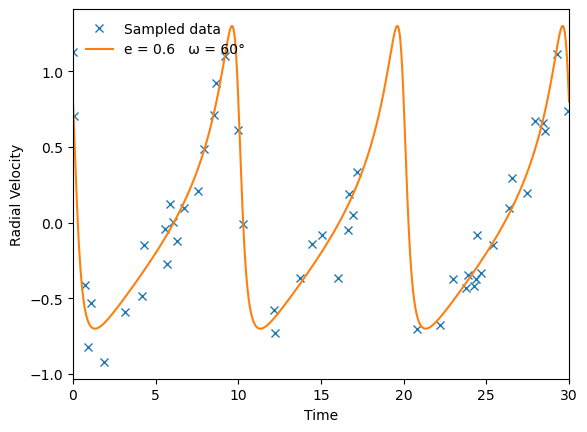

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def find_mean_anomaly(t, t0, P):
    return 2 * np.pi / P * (t-t0)

def f(E, M, e):
    return E - e * np.sin(E) - M

def f_prime(E, e):
    return 1 - e * np.cos(E)

def find_eccentric_anomaly(M_array, e, initial_guess, tol=1e-8, max_iter=100): # through Newton method
    E_array = np.zeros_like(M_array)
    for i, M in enumerate(M_array):
        E = initial_guess[i]  
        for _ in range(max_iter):
            f_val = f(E, M, e)
            if np.abs(f_val) < tol:  
                E_array[i] = E
                break
            f_prime_val = f_prime(E, e)
            E = E - f_val / f_prime_val
        else:
            raise ValueError(f"Failed to converge for M = {M}")
    return E_array

def find_theta_dash_array(E, e):
    numerator = np.cos(E) - e
    denominator = 1 - e * np.cos(E)
    arg = numerator / denominator
    return np.arccos(arg)

def theta_piecewise(E_values, theta_prime_values):
    theta_values = np.zeros_like(E_values)  

    for i, E in enumerate(E_values):
        theta_prime = theta_prime_values[i]
    
        while E >= 2 * np.pi:  # ensures if/else conditions repreated every 2pi
            E -= 2 * np.pi

        if E <= np.pi:
            theta_values[i] = theta_prime
        elif np.pi < E < 2 * np.pi:
            theta_values[i] = 2 * np.pi - theta_prime

    return theta_values

def radial_velocity(K, theta, omega, e, gamma):
    return K * (np.cos(theta + omega) + e * np.cos(omega)) + gamma

def sampling(T, v, Nsamples = 50, noise=0.3):
    choice = np.random.choice(len(T), size=Nsamples, replace=False)
    eps = noise * np.random.randn(len(T)) * np.mean(np.abs(v))
    samples = [T[i] for i in choice], [v[i] + eps[i] for i in choice]
    return samples

##################################################

T = 30                      # Duration
t = np.linspace(0,T,1000)  # Time array
P = 10                      # Period 
t0 = 0                      # Time of Last Periapsis
K = 1                       # Semi amplitude
gamma = 0                   # Instrument velocity offset

# These are the important parameters that change curve shape
e = 0.6                     # Ellipticity
omega = 60                    # Arguement of periapsis (degrees)
omega_rad = omega/180*np.pi  # Arguement of periapsis (Rads)

M_array = find_mean_anomaly(t, t0, P)              # Mean Anomaly
initial_guess = M_array                            # Initial guess for Newton Method
E_array = find_eccentric_anomaly(M_array, e, initial_guess)  # Eccentric anomaly
theta_dash = find_theta_dash_array(E_array, e) 
theta = theta_piecewise(E_array, theta_dash)
rv = radial_velocity(K, theta, omega_rad, e, gamma)    # Radial Velocity
rv_sampled = sampling(t, rv)

plt.plot(rv_sampled[0], rv_sampled[1], 'x', label = "Sampled data")
plt.plot(t, rv, label = "e = " + str(e) + "   \u03C9 = " + str(omega) + "\u00b0")
plt.xlabel("Time")
plt.ylabel("Radial Velocity")
plt.xlim(0,30)
plt.legend(frameon = False, loc = "upper left")
plt.show()
